# 1. SETUP

## import dependencies

In [6]:
# import standard dependencies
import cv2
import numpy as np
import os
import random
from matplotlib import pyplot as plt

# import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Input, Flatten, Dense
import tensorflow as tf

## set gpu growth
- avoid out of memory errors by setting gpu memory consumption growth

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## create folder structures

In [9]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor') 

# 2. COLLECTING DATABASES

In [10]:
# untar LFW dataset 
# !tar -xf lfw.tar

In [11]:
# move LFW images to the negative repository
# for directory in os.listdir('lfw'):
#     for file in os.listdir(os.path.join('lfw', directory)):
#         OLD_PATH = os.path.join('lfw', directory, file)
#         NEW_PATH = os.path.join(NEG_PATH, file)
#         os.replace(OLD_PATH, NEW_PATH)

In [12]:
# Import uid library to generate unique image names
import uuid

In [10]:
#establish a connection to the webcam
cap = cv2.VideoCapture(1)
while cap.isOpened():
    ret, frame = cap.read()
    
    # resize frame to 250X250 pixels 
    # in my mac original frame size = 1080X1920 pixels
    frame = frame[:, 420:1920-420, :]
    frame = cv2.resize(frame, (250, 250))
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANCHOR_PATH, '{}.jpeg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpeg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    # show image back to screen
    cv2.imshow('image capture', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# release the webcam
cap.release()
cv2.destroyAllWindows()
for i in range(1,5):
    cv2.waitKey(1)

# 3. LOAD AND PREPROCESS IMAGES

# get image directories

In [13]:
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+'/*.jpeg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpeg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

Metal device set to: Apple M1 Pro


In [14]:
dir_test = anchor.as_numpy_iterator()

In [15]:
dir_test.next()

b'data/anchor/70df7ec8-c6b2-11ed-b8c5-e6320f567ebd.jpeg'

## preprocessing - scale and resize

In [16]:
def preprocess(FilePath):
    byte_img = tf.io.read_file(FilePath)
    # load in the image
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (105, 105))
    # scale img to be between 0 and 1
    img = img/255.0
    return img

In [17]:
preprocess('data/anchor/64033384-c6b2-11ed-b8c5-e6320f567ebd.jpeg')

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.5790828 , 0.5054111 , 0.43623006],
        [0.6964653 , 0.6253168 , 0.5309191 ],
        [0.7619159 , 0.68348455, 0.57760215],
        ...,
        [0.78478056, 0.71596634, 0.6183007 ],
        [0.7474323 , 0.67684406, 0.5827264 ],
        [0.7168957 , 0.64630747, 0.5521898 ]],

       [[0.49438444, 0.4268708 , 0.36683342],
        [0.62130857, 0.55436176, 0.4753702 ],
        [0.7345539 , 0.6525744 , 0.5563092 ],
        ...,
        [0.76760036, 0.6986594 , 0.6012472 ],
        [0.73025215, 0.65966386, 0.5660664 ],
        [0.71140456, 0.6413766 , 0.5548219 ]],

       [[0.42901608, 0.3776622 , 0.32600597],
        [0.5317127 , 0.470835  , 0.4005269 ],
        [0.6667223 , 0.5925859 , 0.50041133],
        ...,
        [0.7519697 , 0.68138146, 0.5892068 ],
        [0.71571964, 0.64842606, 0.5601974 ],
        [0.7037282 , 0.6392091 , 0.55433506]],

       ...,

       [[0.78944916, 0.65219426, 0.39337072],
        [0.77

## create labelled dataset

In [18]:
# (anchor, postive) => 1, 1, 1, 1, 1
# (anchor, negative) => 0, 0, 0, 0, 0

In [19]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
sample = data.as_numpy_iterator()
ex = sample.next() 

## build train and test partition

In [21]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [22]:
# '*' unpacks the data
res = preprocess_twin(*ex)

In [23]:
res[1]

<tf.Tensor: shape=(105, 105, 3), dtype=float32, numpy=
array([[[0.4552688 , 0.38860214, 0.31801388],
        [0.59048957, 0.5078565 , 0.42494333],
        [0.70869464, 0.6110289 , 0.5138078 ],
        ...,
        [0.22696644, 0.21090665, 0.18915127],
        [0.27599713, 0.24713223, 0.2166067 ],
        [0.4552066 , 0.41720474, 0.36650443]],

       [[0.40736967, 0.34854612, 0.27403632],
        [0.50108045, 0.4296519 , 0.3509404 ],
        [0.6443244 , 0.55450183, 0.46253172],
        ...,
        [0.16283183, 0.14733227, 0.12573028],
        [0.31404588, 0.28797543, 0.256883  ],
        [0.55729634, 0.5276111 , 0.47335607]],

       [[0.37468547, 0.3158619 , 0.24135211],
        [0.43787515, 0.37092838, 0.29193678],
        [0.5549398 , 0.4708128 , 0.38491178],
        ...,
        [0.15826328, 0.15514426, 0.14300607],
        [0.17703754, 0.16153799, 0.14006272],
        [0.3270553 , 0.30707398, 0.2642391 ]],

       ...,

       [[0.8182785 , 0.6731804 , 0.3959628 ],
        [0.78

In [24]:
res[2]

1.0

In [25]:
# build data pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:
# training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [27]:
# testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [28]:
len(test_data)

12

# 4. MODEL ENGINEERING

## neural network layers

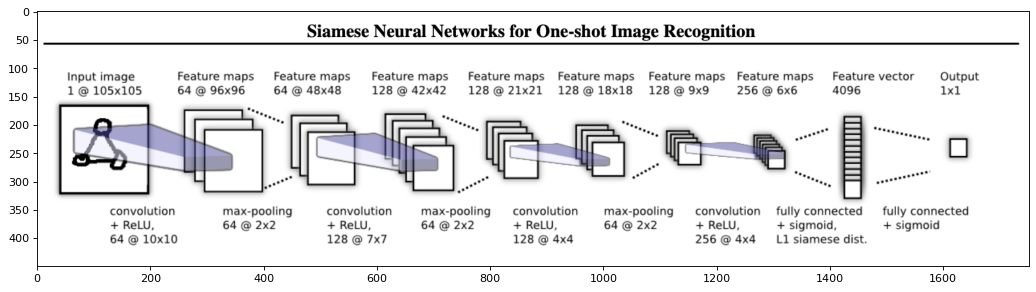

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
figure(figsize=(16, 8), dpi=80)
img = mpimg.imread('network_layer.png')
imgplot = plt.imshow(img)
plt.show()

## make embedding and distance layer

In [30]:
#embedding layer
def make_embedding():
    inp = Input(shape=(105, 105, 3), name='input image')
    
    # first block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp) 
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
    
    # second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)
    
    # third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)
    
    # final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp] ,outputs=[d1], name='embedding')  

In [31]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [32]:
# build distance layer
class L1Dist(Layer):
    
    # init function, performs inheritance
    def __init__(self, **kwargs):
        super().__init__()
        
    # performs distance/similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding-validation_embedding)
        

## make siamese model

In [33]:
def make_siamese_model():
    
    # input anchor image
    input_image = Input(name='input_image', shape=(105, 105, 3))

    # input validation image
    validation_image = Input(name='validation_image', shape=(105, 105, 3))

    # combining the distance
    siamese_model = L1Dist()
    siamese_model._name = 'distance'
    distances = siamese_model(embedding(input_image), embedding(validation_image))

    # classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siamese') 

In [34]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "siamese"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_image[0][0]',            
                                                                  'validation_image[0][0]'] 

# 5. TRAINING

In [35]:
from tensorflow.keras.optimizers.legacy import Adam
# setup loss fuction
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = Adam(1e-4)

In [36]:
# establish checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [37]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        # get anchor and postive/negative images
        X = batch[:2]
        # get label
        y = batch[2]
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # calculate gradient
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # calculate updated weights and apply to siamese models
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

In [39]:
from tensorflow import keras
# build training loop
tensorboard_callback = keras.callbacks.TensorBoard
def train(data, epochs):
    for epoch in range(1, epochs+1):
        print('\n epoch : {}/{}'.format(epoch, epochs))
        progbar = tf.keras.utils.Progbar(len(data))
        
        #loop through each batch
        for idx, batch in enumerate(data):
            # run through train data here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        callbacks=[tensorboard_callback]

In [40]:
# train model
epochs = 50  
train(train_data, epochs)   


 epoch : 1/50


2023-04-29 04:11:03.220507: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 34s 1s/step

 epoch : 2/50
27/27 [==============================] - 33s 1s/step

 epoch : 3/50
27/27 [==============================] - 32s 1s/step

 epoch : 4/50
27/27 [==============================] - 32s 1s/step

 epoch : 5/50
27/27 [==============================] - 33s 1s/step

 epoch : 6/50
27/27 [==============================] - 33s 1s/step

 epoch : 7/50
27/27 [==============================] - 33s 1s/step

 epoch : 8/50
27/27 [==============================] - 32s 1s/step

 epoch : 9/50
27/27 [==============================] - 33s 1s/step

 epoch : 10/50
27/27 [==============================] - 33s 1s/step

 epoch : 11/50
27/27 [==============================] - 32s 1s/step

 epoch : 12/50
27/27 [==============================] - 33s 1s/step

 epoch : 13/50
27/27 [===================

# 6. EVALUATE MODEL

In [41]:
# import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [42]:
# get a batch of test data
test_inp, test_val, y_true = test_data.as_numpy_iterator().next()

In [43]:
# make predictions
y_hat = siamese_model.predict([test_inp, test_val])
y_hat

1/1 [==============================] - 0s 143ms/step


array([[1.0000000e+00],
       [9.9970567e-01],
       [1.0000000e+00],
       [7.4799209e-05],
       [9.9999762e-01],
       [9.9998319e-01],
       [3.1076972e-10],
       [4.3554093e-07],
       [9.9999940e-01],
       [4.4768148e-12],
       [9.9997807e-01],
       [9.9999940e-01],
       [2.2484379e-09],
       [2.9749613e-08],
       [9.9999952e-01],
       [1.0146120e-09]], dtype=float32)

In [51]:
# post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]

In [52]:
y_true

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

In [53]:
# creating a metric object
m = Recall()

# calculate the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

1.0

In [54]:
# creating a metric object
m = Precision()

# calculate the recall value
m.update_state(y_true, y_hat)

# return recall result
m.result().numpy()

1.0

In [48]:
# visualizing results
# plt.figure(figsize=(10, 8))
# plt.subplot(1, 2, 1)
# plt.imshow(test_inp[1])
# plt.subplot(1, 2, 2)
# plt.imshow(test_val[1])
# plt.show()

# 7. SAVE  

In [46]:
siamese_model.compile(optimizer='adam', loss='BinaryCrossentropy')

In [49]:
#saving weights
siamese_model.save('siamese_model_3.h5')

In [50]:
# reload model
model = tf.keras.models.load_model('siamese_model_3.h5', 
                                          custom_objects={'L1Dist':L1Dist, 
                                                  'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [50]:
model.predict([test_inp, test_val], verbose=0) 

array([[1.0000000e+00],
       [9.9999738e-01],
       [1.5506021e-10],
       [3.1524213e-08],
       [1.0000000e+00],
       [9.9999988e-01],
       [1.2404997e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.7667583e-09],
       [9.9984044e-01],
       [9.9999940e-01],
       [1.2025563e-06],
       [6.3376704e-10],
       [9.9999809e-01],
       [1.0631853e-11]], dtype=float32)

# REAL TIME TEST

## verification function

In [55]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpeg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
        
    detection = np.sum(np.array(results) > detection_threshold)
    validation = detection/len(os.listdir(os.path.join('application_data', 'verification_image')))
    verified = validation > verification_threshold
    
    return results, verified

 ## opencv real time verification

In [59]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    
    ret, frame = cap.read()
    frame = frame[:, 420:1920-420, :]
    frame = cv2.resize(frame, (250, 250))
     
    cv2.imshow('verification', frame)
    
    # verification trigger
    if cv2.waitKey(10) & 0XFF==ord('v'):
        # save input imgage to input_image folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpeg'), frame)
        # run verification function
        results, verified = verify(model, 0.5, 0.5)
        print(verified)
        
    if cv2.waitKey(10) & 0XFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()  
for i in range(1,5):
    cv2.waitKey(1)